In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lineartree import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
### READ DATA ###

df = pd.read_csv('cs-training.csv.zip', index_col=0)

print(df.shape)
df.head()

(150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
### SEPARATE X FROM Y ###

X,y = df.copy().drop('SeriousDlqin2yrs', axis=1), df['SeriousDlqin2yrs'].copy()
X.fillna(X.mean(), inplace=True)

X.shape, y.shape

((150000, 10), (150000,))

In [4]:
### FIT LINEAR TREE ###

model = LinearTreeClassifier(
    RidgeClassifier(), 
    max_depth=5, min_samples_leaf=1500, max_bins=20
)
model.fit(X,y)

LinearTreeClassifier(base_estimator=RidgeClassifier(), max_bins=20,
                     min_samples_leaf=1500)

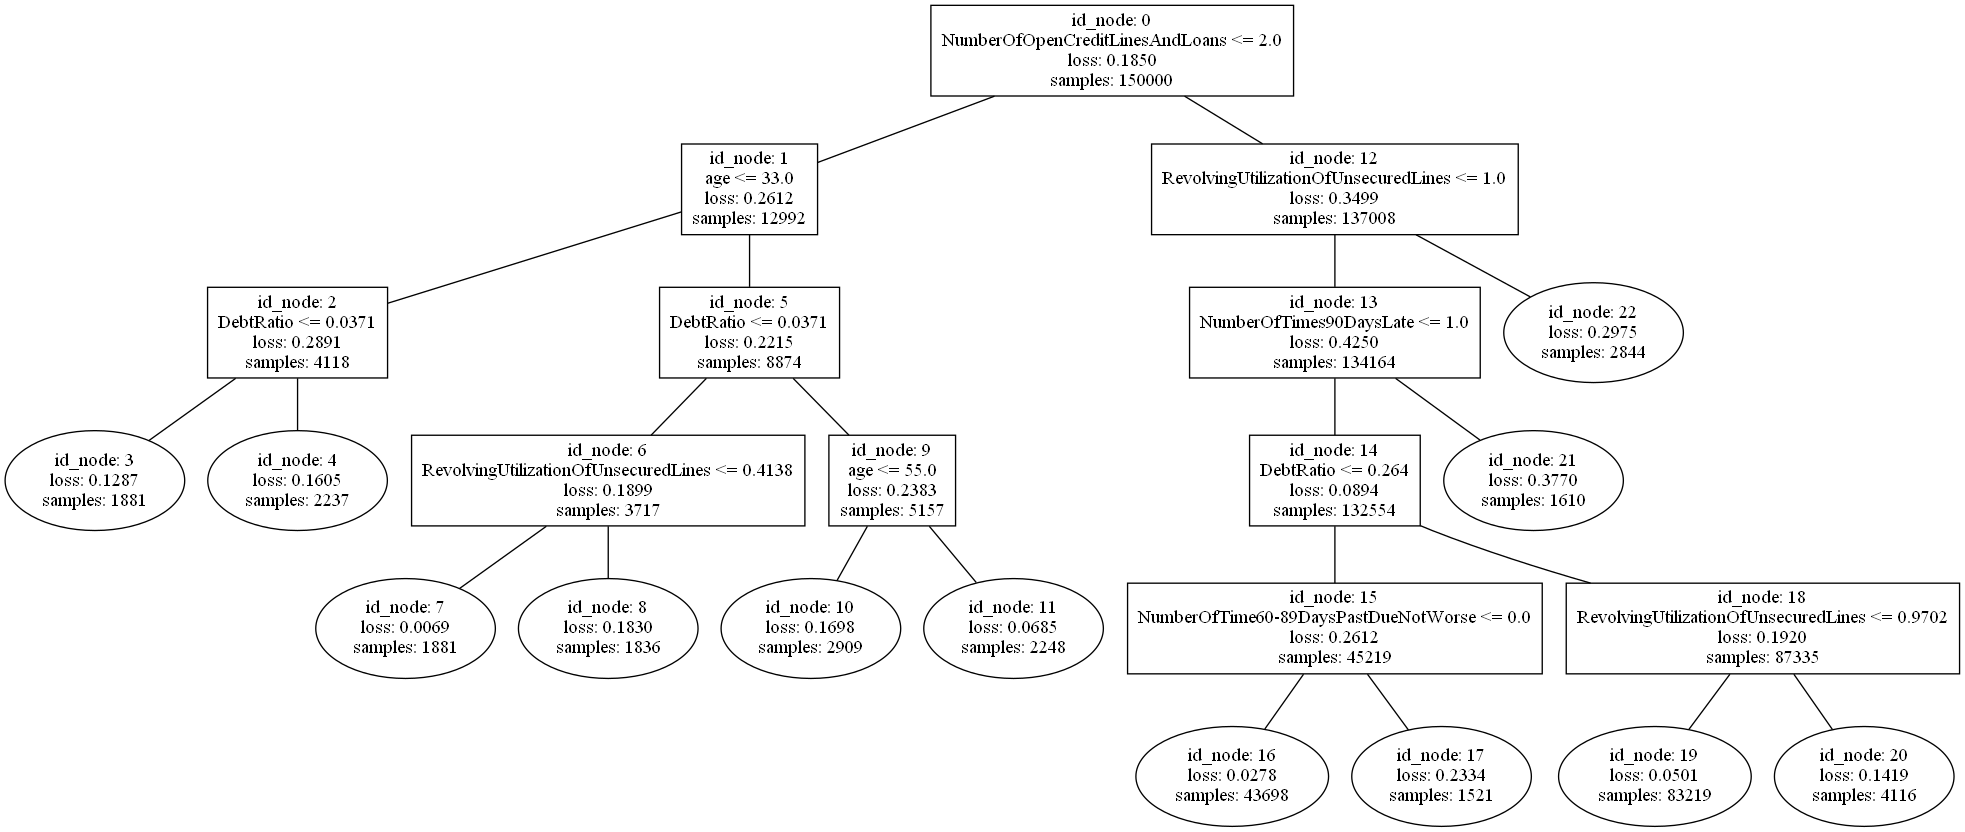

In [5]:
### PLOT TREE STRUCTURE ###

model.plot_model(feature_names=X.columns)

In [6]:
### DEFINE UTILITY FUNC TO EXTRACT RULES ###

def get_rules(model, feature_names=None):
    
    summary = model.summary(feature_names=feature_names)
    leaves = model.summary(only_leaves=True).keys()
    rules = {}

    for leaf in leaves:
        final_leaf = leaf
        conditions = []
        while leaf != 0:
            for l,info in summary.items():
                if 'children' in info:
                    if leaf in info['children']:
                        th = info['th']
                        col = (info['col'] if feature_names is not None else 
                               "X[{}]".format(info['col']))
                        direct = '<=' if leaf == info['children'][0] else '>'
                        cond = '({} {} {})'.format(col, direct, th)
                        conditions.append(cond)
                        leaf = l

        conditions = list(reversed(conditions))
        rules['leaf {}'.format(final_leaf)] = ' AND '.join(conditions)
        
    return rules

In [7]:
### EXTRACT RULES ###

rules = get_rules(model, X.columns)
rules

{'leaf 3': '(NumberOfOpenCreditLinesAndLoans <= 2.0) AND (age <= 33.0) AND (DebtRatio <= 0.0371)',
 'leaf 4': '(NumberOfOpenCreditLinesAndLoans <= 2.0) AND (age <= 33.0) AND (DebtRatio > 0.0371)',
 'leaf 7': '(NumberOfOpenCreditLinesAndLoans <= 2.0) AND (age > 33.0) AND (DebtRatio <= 0.0371) AND (RevolvingUtilizationOfUnsecuredLines <= 0.4138)',
 'leaf 8': '(NumberOfOpenCreditLinesAndLoans <= 2.0) AND (age > 33.0) AND (DebtRatio <= 0.0371) AND (RevolvingUtilizationOfUnsecuredLines > 0.4138)',
 'leaf 10': '(NumberOfOpenCreditLinesAndLoans <= 2.0) AND (age > 33.0) AND (DebtRatio > 0.0371) AND (age <= 55.0)',
 'leaf 11': '(NumberOfOpenCreditLinesAndLoans <= 2.0) AND (age > 33.0) AND (DebtRatio > 0.0371) AND (age > 55.0)',
 'leaf 16': '(NumberOfOpenCreditLinesAndLoans > 2.0) AND (RevolvingUtilizationOfUnsecuredLines <= 1.0) AND (NumberOfTimes90DaysLate <= 1.0) AND (DebtRatio <= 0.264) AND (NumberOfTime60-89DaysPastDueNotWorse <= 0.0)',
 'leaf 17': '(NumberOfOpenCreditLinesAndLoans > 2.0) A

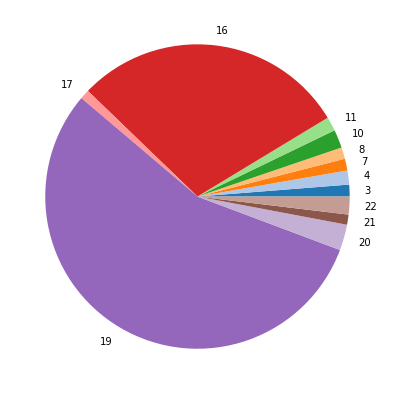

In [8]:
### COUNT HOW MANY TRAINING SAMPLES IN EACH LEAF ###

leaves = model.apply(X)
leaves_count = pd.value_counts(leaves).sort_index()
leaves_count.name = 'counts'

plt.figure(figsize=(7,7))
palette = plt.get_cmap('tab20').colors
plt.pie(leaves_count, labels=leaves_count.index, colors=palette)
plt.show()

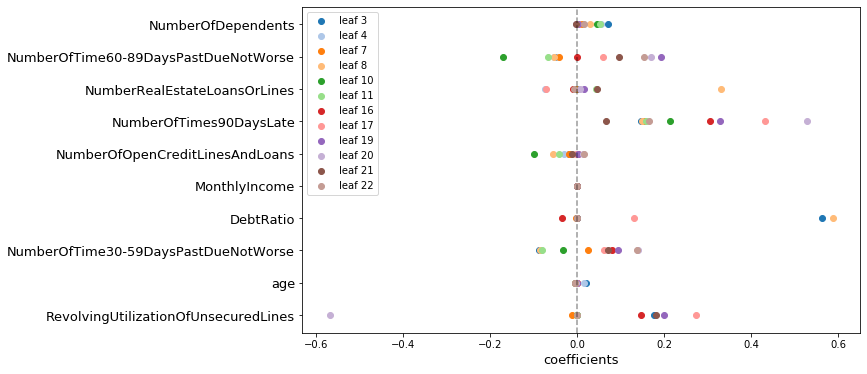

In [9]:
### PLOT COEFFICIENTS FROM LINEAR MODELS IN LEAVES ###

plt.figure(figsize=(10,6))
for _,(i,leave) in enumerate(model.summary(only_leaves=True).items()):
    coef_ = leave['models'].coef_[0]
    plt.scatter(coef_, range(X.shape[1]), label='leaf {}'.format(i), c=[palette[_%len(palette)]])

plt.axvline(0, linestyle='--', c='black', alpha=0.4)
plt.yticks(range(X.shape[1]), X.columns, size=13)
plt.xlabel('coefficients', size=13); plt.legend(); plt.show()   

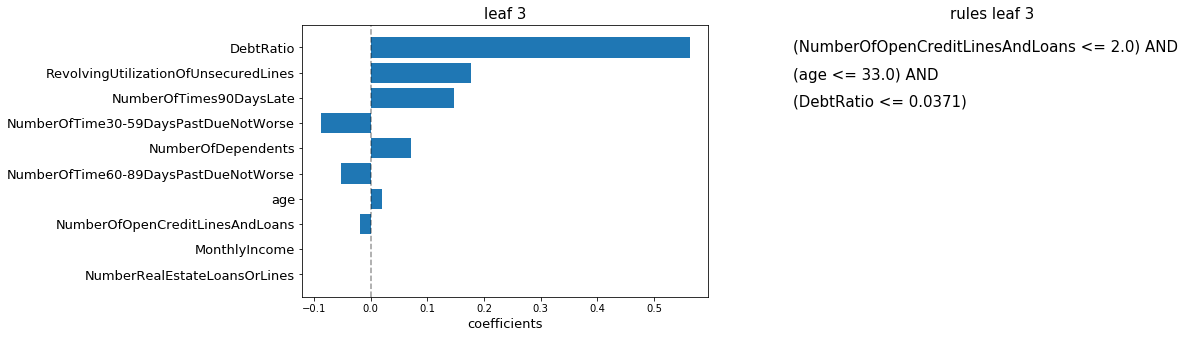

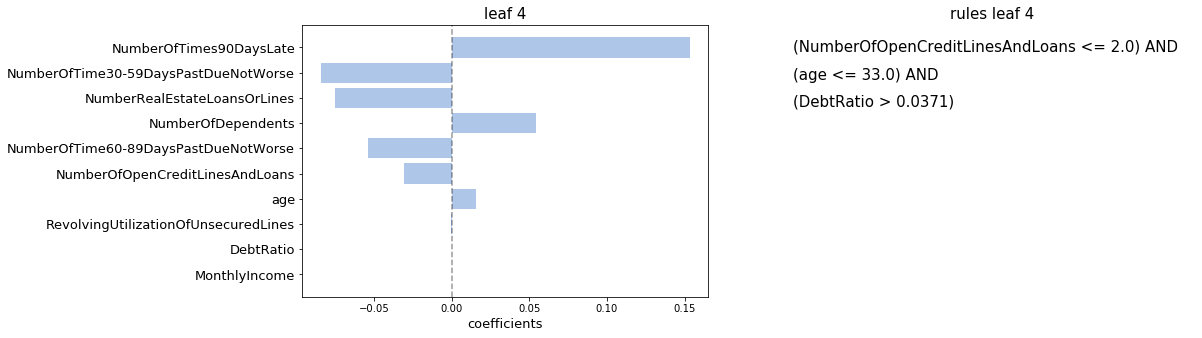

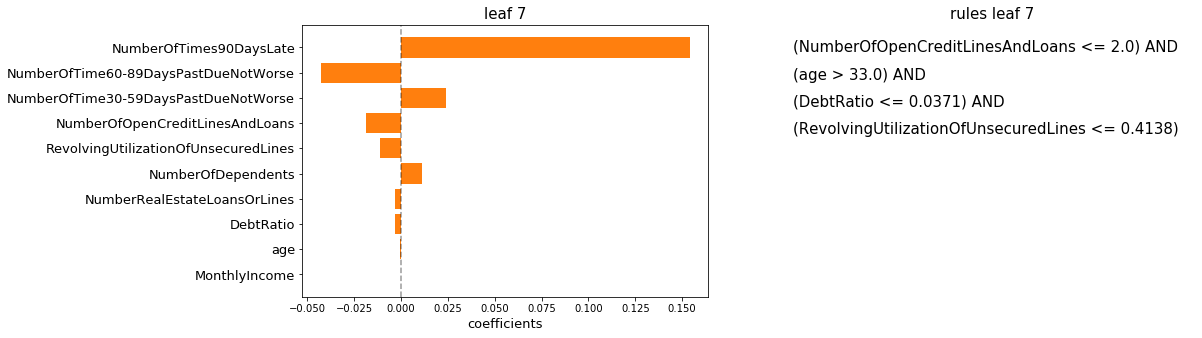

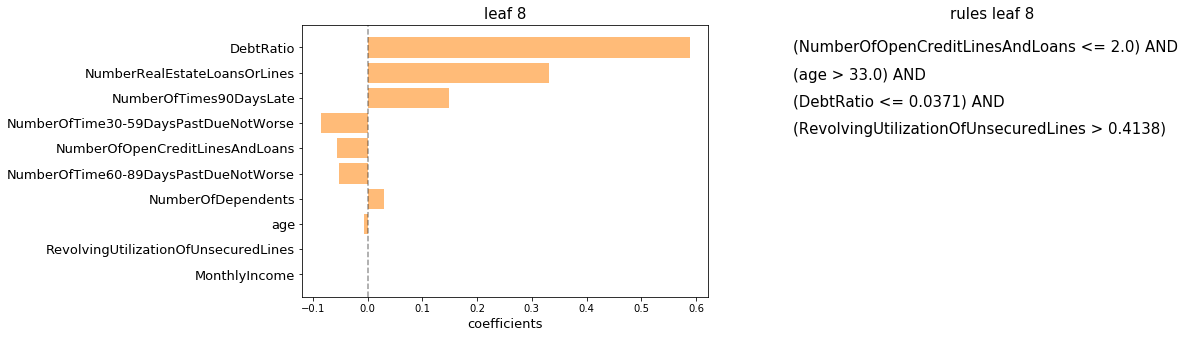

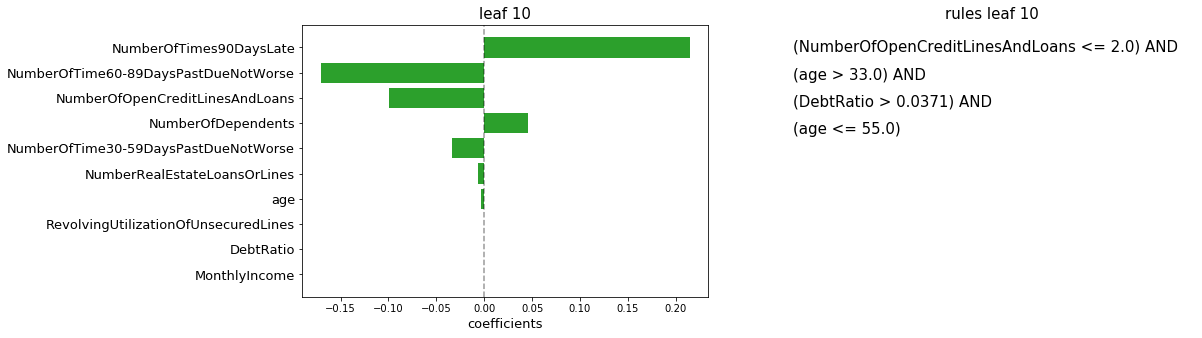

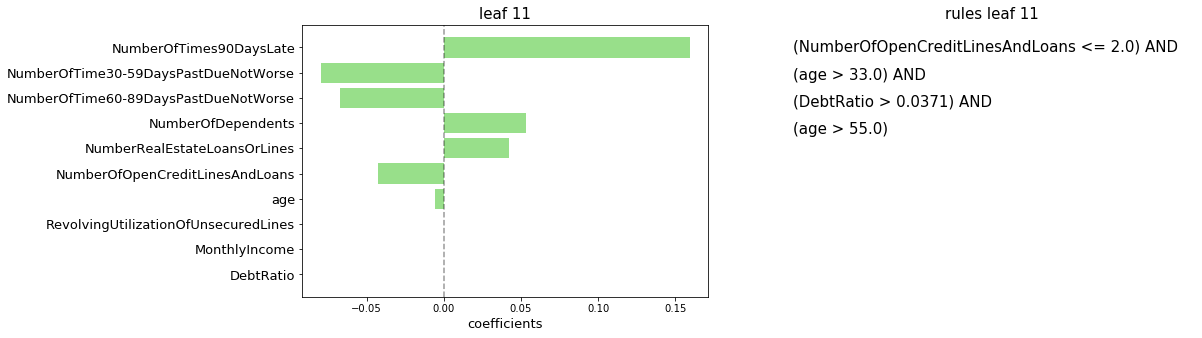

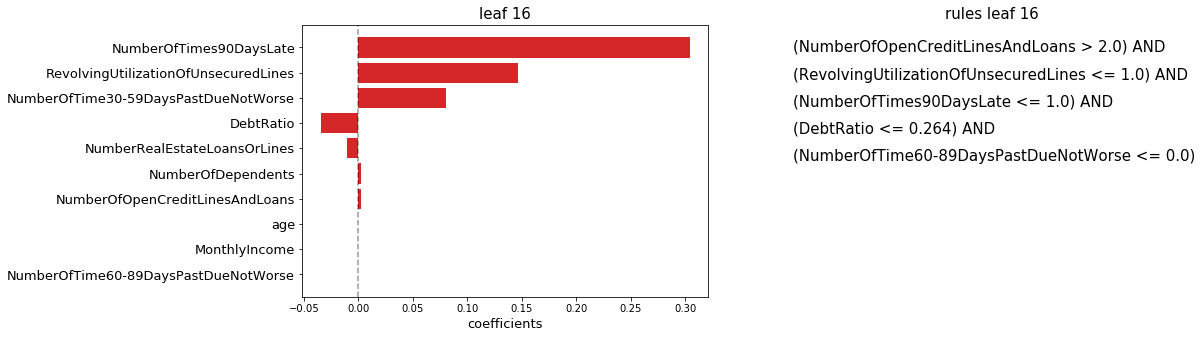

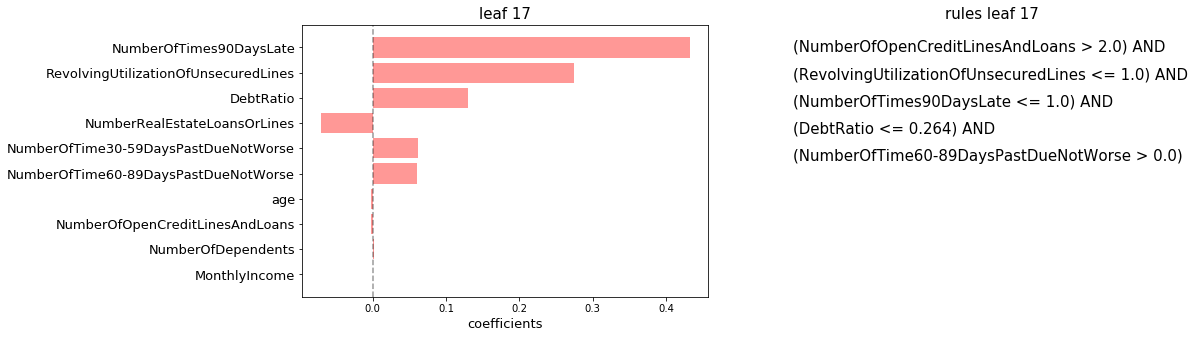

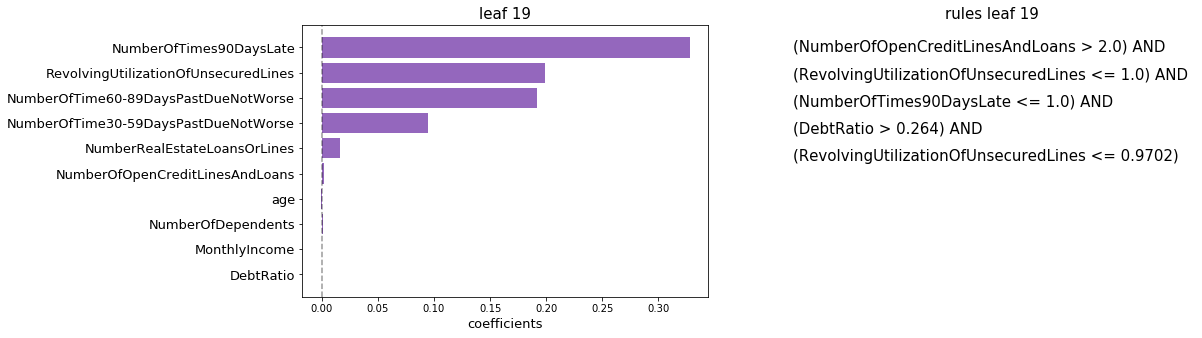

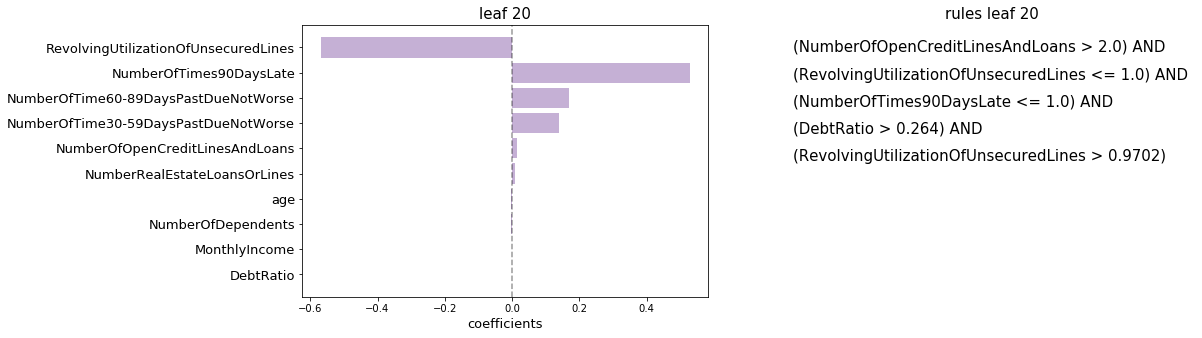

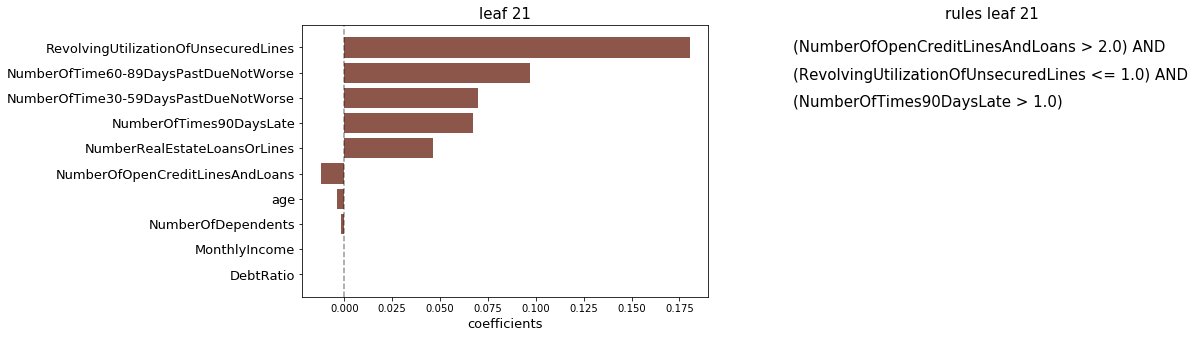

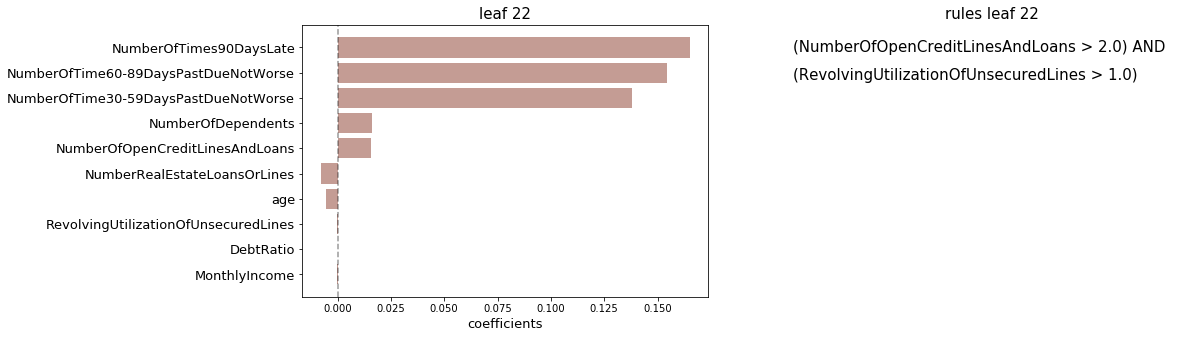

In [10]:
### PLOT COEFFICIENTS FROM LINEAR MODELS AND DECISION RULES IN EACH LEAF ###

for _,(i,leaf) in enumerate(model.summary(only_leaves=True).items()):
    
    if hasattr(leaf['models'], 'coef_'):
        coef_ = leaf['models'].coef_[0]
        order = np.argsort(np.abs(coef_))
    else:
        coef_ = np.zeros((X.shape[1],))
        order = np.arange(X.shape[1])
        
    text = rules['leaf {}'.format(i)].split(' AND ')
    
    plt.figure(figsize=(16,5))
    
    plt.subplot(121)
    plt.axvline(0, linestyle='--', c='black', alpha=0.4)
    plt.barh(range(X.shape[1]), coef_[order], color=[palette[_%len(palette)]])
    plt.yticks(range(X.shape[1]), X.columns[order], size=13)
    plt.title('leaf {}'.format(i), size=15); plt.xlabel('coefficients', size=13)
    
    plt.subplot(122)
    __ = 0.1
    for rule in text:
        rule = rule if rule == text[-1] else rule + ' AND'
        plt.text(0.01, 1-__, rule, size=15)
        __ += 0.1
    plt.title('rules leaf {}'.format(i), size=15); plt.axis('off')   
    
    plt.show()